# Moscow Housing, Group 86
Henrik Ytrehus Ågotnes, studentnr: 491752

Alexander Michael Gerlach, studentnr: 557833

Fredrik Veidahl Aagaard, studentnr: 759482

**NOTE:** We manually selected two scores on kaggle. We attached the files to our submission marked as `submission_model1.csv` with a (public) score of 0.15885 corresponding to model 1 and `submission_model2.csv` with a (public) score of 0.15959 corresponding to model2. Both models are in this notebook. 

# Data Preparation

In [1]:
import pandas as pd
import json
import math
import numpy as np
import geopy.distance
import geojson
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon
from sklearn.neighbors import NearestNeighbors
import seaborn as sns
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import KFold
from tqdm import tqdm
from sklearn.metrics import mean_squared_log_error
from sklearn.ensemble import RandomForestRegressor
import lightgbm as lgbm
from catboost import CatBoostRegressor
from sklearn.ensemble import BaggingRegressor
from xgboost import XGBRegressor

pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 200)

## Load data

In [2]:
apartments_train = pd.read_csv('data/apartments_train.csv')
buildings_train = pd.read_csv('data/buildings_train.csv')
apartments_test = pd.read_csv('data/apartments_test.csv')
buildings_test = pd.read_csv('data/buildings_test.csv')

train = pd.merge(
    apartments_train, 
    buildings_train.set_index('id'), 
    how='left', 
    left_on='building_id', 
    right_index=True
)
test = pd.merge(
    apartments_test, 
    buildings_test.set_index('id'), 
    how='left', 
    left_on='building_id', 
    right_index=True
)

## Replace missing coordinates and districts

**EDA insight:** The test set was missing the coordinates for a single building. Using the address, we could simply obtain the coordinates using Google Maps.

In [3]:
ind = test[test["longitude"].isna()].index
test.at[ind, "latitude"] = 55.56776345324702
test.at[ind, "longitude"] = 37.48171529826662

**EDA insight:** Some districts were missing in both the train and test set. We noticed that all buildings were located outside of any district in moscow. Hence, we added another category (12: "other_district") to handle the nan values.

In [4]:
ind = train[train.district.isna()].index
train.at[ind, "district"] = 12
ind = test[test.district.isna()].index
test.at[ind, "district"] = 12

## Fixing incorrect coordinates in testset

**EDA insight:** We noticed that some apartments in the testset were pretty far away from moscow. A more detailed analysis of the address revealed that they were actually located in moscow, but the coordinates were wrong. Hence, we replaced the wrong coordinates with the correct ones using Google Maps and the given address.

In [5]:
apartment_coordinates = {
    2511: [55.5438629741104, 37.48233890768276],
    2529: [55.66866253043727, 37.217152651528785],
    4719: [55.63132797843279, 37.426744466015705],
    5090: [55.54390546580924, 37.48229599441532],
    6959: [55.54390546580924, 37.48229599441532],
    8596: [55.54390546580924, 37.48229599441532],
    9547: [55.63399775464791, 37.41982879208156]
}
for k, v in apartment_coordinates.items():
    test.at[k, "latitude"] = v[0]
    test.at[k, "longitude"] = v[1]

## Transforming price
We performed to transformations of the target feature `price` since the skewness is quite high. We computed the `log_price` and the `price_per_m2` based on the total area.

In [6]:
train["log_price"] = np.log1p(train.price)
train["price_per_m2"] = train.price / train.area_total

# Exploratory Data Analysis

## Domain Knowledge

### Expensive districts
There are a range of districts within Moscow that are notorious for expensive apartments according to [Russia Beyond](https://www.rbth.com/travel/332318-expensive-rich-districts-moscow), including Khamovniki, Yakimanka, Arbat, Presnensky, Tverskoy, Meschansky, and Zamoskvorechye. Based on this information,
we created a set of features (is_in_khamovniki, is_in_yakimanka, etc.) using the polygon coordinates for each district obtained from open street map.

In order to extract the polygon coordinates from open stree map, we firstly looked up the district on osm, revealing an id of the corresponding district. Thereafter, we extracted the polygon data using a publicly available [extraction tool](http://polygons.openstreetmap.fr/index.py) by simply parsing the corresponding ID. This allowed us to download the polygon data as a GeoJSON file, which we could then work on to see if a given apartment is within the district or not. We used the `shapely` package to create a polygon of the data. Finally, we created a point for each row based on latitude and longitude and simply checked if the point is within the polygon using `shapely`.

The data extracted from open street map can be found in the data folder: `data/geojson/<district_name>_polygon_data.geojson`.

Despite our efforts, the added districts did not improve the score at all.

In [7]:
def wealthy_districts_features(data):
    with open("data/geojson/khamovniki_polygon_data.geojson") as f:
        gj_khamovniki = geojson.load(f)
    with open("data/geojson/yakimanka_polygon_data.geojson") as f:
        gj_yakimanka = geojson.load(f)
    with open("data/geojson/arbat_polygon_data.geojson") as f:
        gj_arbat = geojson.load(f)
    with open("data/geojson/presnensky_polygon_data.geojson") as f:
        gj_presnensky = geojson.load(f)
    with open("data/geojson/Tverskoy_polygon_data.geojson") as f:
        gj_tverskoy = geojson.load(f)
    khamovniki_polygon = Polygon(gj_khamovniki["geometries"][0]["coordinates"][0][0])
    yakimanka_polygon = Polygon(gj_yakimanka["geometries"][0]["coordinates"][0][0])
    arbat_polygon = Polygon(gj_arbat["geometries"][0]["coordinates"][0][0])
    presnensky_polygon = Polygon(gj_presnensky["geometries"][0]["coordinates"][0][0])
    tverskoy_polygon = Polygon(gj_tverskoy["geometries"][0]["coordinates"][0][0])
    for ind, row in data.iterrows():
        point = Point([row["longitude"], row["latitude"]])
        data.at[ind, "is_in_khamovniki"] = 1 if khamovniki_polygon.contains(point) else 0
        data.at[ind, "is_in_yakimanka"] = 1 if yakimanka_polygon.contains(point) else 0
        data.at[ind, "is_in_arbat"] = 1 if arbat_polygon.contains(point) else 0
        data.at[ind, "is_in_presnensky"] = 1 if presnensky_polygon.contains(point) else 0
        data.at[ind, "is_in_tverskoy"] = 1 if tverskoy_polygon.contains(point) else 0

### Metro stations
Moscow has a sophisticated metro network comprising 15 lines. Using a public list on [Wikipedia](https://en.wikipedia.org/wiki/List_of_Moscow_Metro_stations) comprising all stations and transitions, we constructed a wide range of features, including the distance to the nearest station, the number of lines that can be reached from that station, and whether or not a specific metro line is accessible.

We used a [table-to-csv parser](https://www.convertcsv.com/html-table-to-csv.htm) to extract the data from wikipedia. Afterwards we had to do a lot of manual data cleaning. For each metro line, we added a boolean variable indictating whether or not the line is rechable from a given station. This was based on the information given on wikipedia. We also had to format the coordinates as there were some undesired characters present in some of the rows. The final input data (moscow-metro-data.csv) is attached to the submission in the data folder.

In [8]:
def distance_to_metro_feature(data, add_metro_lines=True):
    d = data.copy()

    metro_data = pd.read_csv("data/moscow_metro_data.csv", delimiter=";")

    # drop duplicates
    ind = metro_data[metro_data["English transcription"].duplicated()].index
    metro_data = metro_data.drop(ind)
    metro_data = metro_data.reset_index()
    metro_lines = ["metro_line_{}".format(i) for i in range(1, 16)]

    nbrs = NearestNeighbors(n_neighbors=1, algorithm="ball_tree").fit(metro_data[["latitude", "longitude"]])
    distances, indices = nbrs.kneighbors(d[["latitude", "longitude"]])
    d["metro_index"] = indices

    for ind, row in d.iterrows():
        metro_coordinate = metro_data.loc[[row.metro_index]][["latitude", "longitude"]].to_numpy()
        distance = geopy.distance.distance([[row["latitude"], row["longitude"]]], metro_coordinate).km
        data.at[ind, "distance_to_metro"] = distance

        if add_metro_lines:
            number_of_metro_lines = 0
            metro_lines_data = metro_data.loc[[row.metro_index]][metro_lines]
            for metro_line in metro_lines:
                access_to_line = metro_lines_data[metro_line].values[0]
                data.at[ind, metro_line] = access_to_line
                if access_to_line == 1:
                    number_of_metro_lines += 1
            data.at[ind, "number_of_metro_lines"] = number_of_metro_lines

### Universities
Moscow has a great number of universities. However, two of the most important universities are the Moscow State University and the Technical University of Moscow. Apartments close to the universities have a tendency to increase in price. Hence, we added a feature measuring the distance to both universities. 

**Data retrieval:** We retrieved the coordinates of the universities from Google Maps, simply using the names of the universities.

In [9]:
def distance_to_universities_feature(data):
    state_uni_coordinates = [55.70444300116007, 37.528611852796914]
    tech_uni_coordinates = [55.76666597872545, 37.68511242319504]
    distances_to_state_uni = []
    distances_to_tech_uni = []
    for ind, row in data.iterrows():
        distances_to_state_uni.append(geopy.distance.distance([row["latitude"], row["longitude"]], state_uni_coordinates).km)
        distances_to_tech_uni.append(geopy.distance.distance([row["latitude"], row["longitude"]], tech_uni_coordinates).km)
    data["distance_to_state_uni"] = distances_to_state_uni
    data["distance_to_tech_uni"] = distances_to_tech_uni

### Distance to city center
Apartments closer to the city center often have a higher price than those further away. Hence, we created a distance_to_center feature based on latitude and longitude giving the distance to the center of moscow in kilometers.

In [10]:
def distance_to_center_feature(data):
    moscow_center = [55.751244, 37.618423]
    coordinates = data[['latitude', 'longitude']].to_numpy()
    dist = [geopy.distance.distance(moscow_center, coordinate).km for coordinate in coordinates]
    data['distance_to_center'] = dist

### Bearing
We noticed that apartments in the center and western part of moscow tend to have higher prices than others. Thus, we calculated the bearing from the city center based on the latitude and longitude coordinates.

In [11]:
def bearing_feature(data):
    for ind, row in data.iterrows():
        moscow_center = [55.751244, 37.618423]
        c1 = moscow_center
        c2 = [row["latitude"], row["longitude"]]
        y = np.sin(c2[1] - c1[1]) * np.cos(c2[0])
        x = np.cos(c1[0]) * np.sin(c2[0]) - np.sin(c1[0]) * np.cos(c2[0]) * np.cos(c2[1] - c1[1])
        rad = np.arctan2(y, x)
        bearing = ((rad * 180 / np.pi) + 360) % 360
        data.at[ind, "bearing"] = bearing

### Box areas
We further split the map into different coordinate tiles to better capture the more expensive apartments.
The boxes are squares of size 0.025*0.025, and only squares with high correlation were included. The feature names refer the coordinate name of the southwest corner of the box. 

In [12]:
def add_box_areas_more_boxes(data):
    """only add values in list to prevent unnecessary slowdown"""
    locs_with_high_corr = [
            'loc_37.575_55.75', 'loc_37.6_55.725', 'loc_37.525_55.75',
           'loc_37.55_55.775', 'loc_37.525_55.725', 'loc_37.575_55.725',
           'loc_37.525_55.7', 'loc_37.5_55.7', 'loc_37.55_55.725',
           'loc_37.475_55.7', 'loc_37.625_55.725', 'loc_37.5_55.75',
           'loc_37.525_55.775', 'loc_37.525_55.675', 'loc_37.55_55.675',
           'loc_37.55_55.75', 'loc_37.4_55.6', 'loc_37.725_55.575',
           'loc_37.925_55.675', 'loc_37.475_55.55', 'loc_37.65_55.575',
           'loc_37.525_55.875', 'loc_37.5_55.55', 'loc_37.475_55.525',
           'loc_37.925_55.7'
    ]
    for lon in np.arange(37.4, 37.95, 0.025):
        for lat in np.arange(55.525, 55.9, 0.025):
            column_name = "loc_" + str(round(lon, 3)) + "_" + str(round(lat, 3))
            if column_name in locs_with_high_corr: #column_name in locs_with_high_corr:
                data[column_name] = 0
                indexes = data[
                    (lon < data['longitude']) & (data['longitude'] < lon + 0.025) & (lat < data['latitude']) & (
                                data['latitude'] < lat + 0.025)
                    ].index

                data.loc[indexes, column_name] = 1

### Clusters
We also used clustering with kmeans with regard to latitude and longitude. The clusters are based on both train and test coordinates. We later create dummy variables for each cluster. This suprisingly did not work as well as the box-areas. 

In [13]:
from sklearn.cluster import KMeans

def add_clusters(train_data, test_data):
    kmeans = KMeans(n_clusters=100, random_state=0)
    s1 = train_data.longitude
    s2 = test_data.longitude
    f1 = train_data.latitude
    f2 = test_data.latitude
    kmeans.fit(pd.concat([pd.concat([s1, s2]), pd.concat([f1, f2]) ], axis=1))
    train_data['clusters'] = kmeans.predict(train_data[['longitude', 'latitude']])
    pd.get_dummies(train_data, columns=['clusters'])
    test_data['clusters'] = kmeans.predict(test_data[['longitude', 'latitude']])
    test_data = pd.get_dummies(test_data,columns=['clusters'])

### Features Construction (NOTE: Takes some time)

In [14]:
def construct_features(data):
    distance_to_center_feature(data)
    distance_to_metro_feature(data, False)
    bearing_feature(data)
    distance_to_universities_feature(data)
    #wealthy_districts_features(data)
    add_box_areas_more_boxes(data)

train_with_feats = train.copy()
test_with_feats = test.copy()
construct_features(train_with_feats)
construct_features(test_with_feats)
add_clusters(train_with_feats, test_with_feats)

## Understand how the data was generated

### building_id

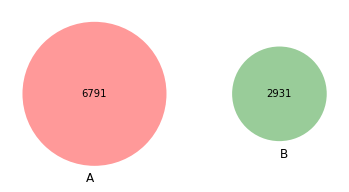

In [15]:
from matplotlib_venn import venn2, venn2_circles
import matplotlib.pyplot as plt

train_buildings = set(train.building_id.values)
test_buildings = set(test.building_id.values)
venn2([train_buildings, test_buildings])
plt.show()

As we can see from the venn diagram above, there is no overlap between the building_ids in the training and test data, showing that the buildings in the test data are completely different from those in the training data. Hence, in order to obtain accurate results during model validation, the training set should be split in a validation and training set based on the same assumptions.

## Explore individual features

In [16]:
def plot_feature_distribution(data, feature, bins=100, ax=None):
    sns.histplot(data[feature], bins=bins, ax=ax)

def plot_all_distributions(data):
    cols = len(data.columns)
    n_rows = n_cols = math.ceil(math.sqrt(cols))
    # Create the subplots
    fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(15,18))
    fig.tight_layout(pad=3.0)
    for i, feature in enumerate(data.columns):
        if feature in ['street', 'address']:
           continue
        plot_feature_distribution(data, feature, ax=axes[i//n_cols,i%n_cols])
    plt.show()

To get a sense of how the features in the dataset are distributed, we plot their distribution. This gives some insight into how we can clean up features if needed.

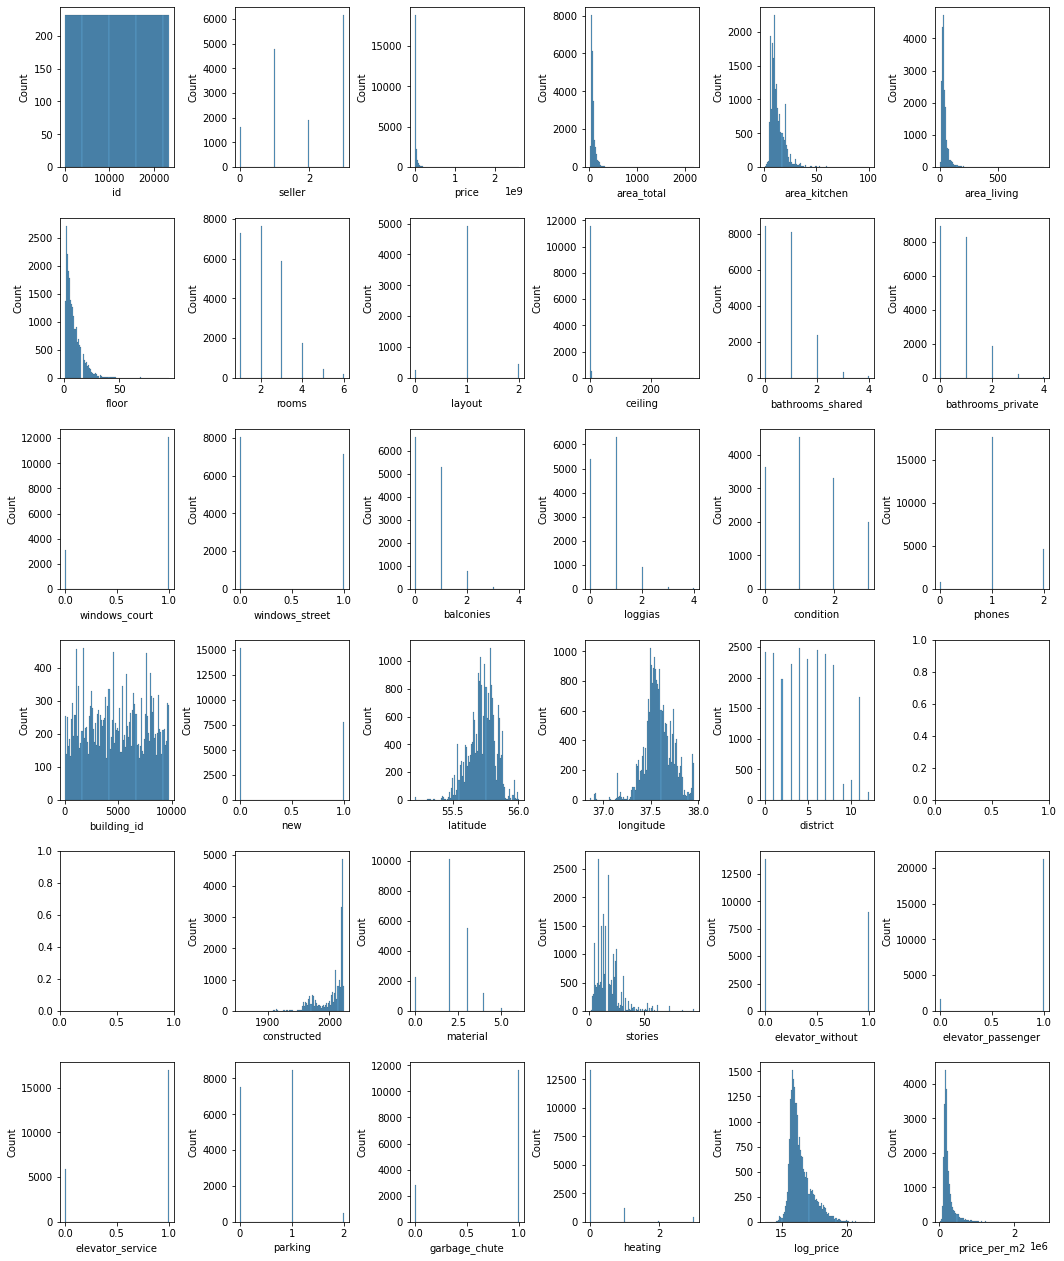

In [17]:
plot_all_distributions(train)

### Price

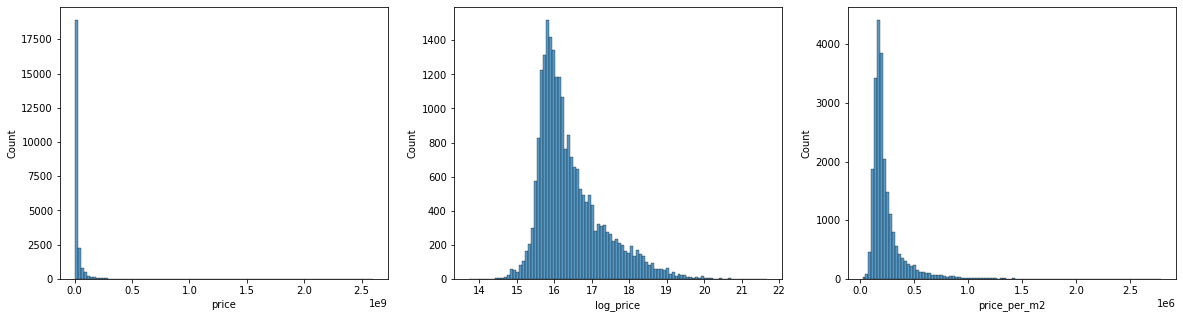

In [18]:
train_with_feats["log_price"] = np.log1p(train_with_feats.price)
train_with_feats["price_per_m2"] = train_with_feats.price / train_with_feats.area_total

fig, ax = plt.subplots(1, 3, figsize=(20, 5))
plot_feature_distribution(train_with_feats, 'price', ax=ax[0])
plot_feature_distribution(train_with_feats, 'log_price', ax=ax[1])
plot_feature_distribution(train_with_feats, 'price_per_m2', ax=ax[2])
plt.show()

**EDA insight:** As we can see, the unadjusted price is significantly right skewed. While computing the price per square meter looks a bit better, a log transformation of the price is even better.

### Areas

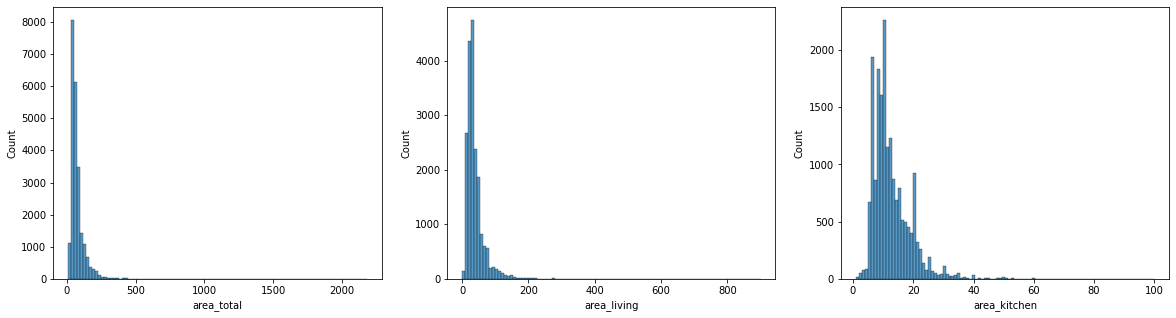

Skewness in training data:


,area_total,area_living,area_kitchen
Skew,8.610355,5.319536,2.207571


In [19]:
fig, ax = plt.subplots(1, 3, figsize=(20, 5))
plot_feature_distribution(train_with_feats, 'area_total', ax=ax[0])
plot_feature_distribution(train_with_feats, 'area_living', ax=ax[1])
plot_feature_distribution(train_with_feats, 'area_kitchen', ax=ax[2])
plt.show()

print("Skewness in training data:")
skew_feats = train_with_feats[['area_total', 'area_kitchen','area_living']].skew().sort_values(ascending=False)
pd.DataFrame({'Skew': skew_feats}).T

**EDA insight**: Area total and area_living are skewed, but a log transformation did not improve model performance. Hence, it was disregarded for the final model.

### Ceiling

Before fixing ceiling values in train set


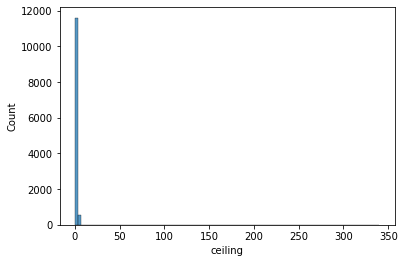

After changing ceiling values in train set


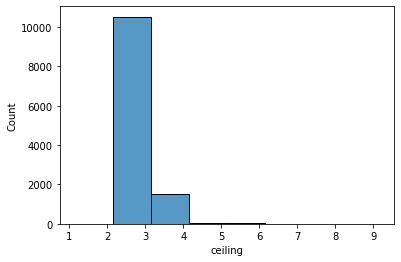

In [20]:
print("Before fixing ceiling values in train set")

plot_feature_distribution(train_with_feats, 'ceiling')
plt.show()

train_with_feats.loc[train_with_feats.ceiling > 100, 'ceiling']/=100
train_with_feats.loc[((train_with_feats.ceiling > 10) & (train_with_feats.ceiling < 100)), 'ceiling']/=10
train_with_feats.loc[(train_with_feats.ceiling < 1), 'ceiling'] = pd.NA

test.loc[test.ceiling > 100, 'ceiling']/=100
test.loc[((test.ceiling > 10) & (test.ceiling < 100)), 'ceiling']/=10
test.loc[(test.ceiling < 1), 'ceiling'] = pd.NA

print("After changing ceiling values in train set")
plot_feature_distribution(train_with_feats, 'ceiling')

**EDA insight**: We see from the ceiling distribution that some of the values must be wrong. We assume this is because they have been input using different measurements (i.e. meters, centimeters etc.). We therefore transform them to be in the interval 1-10m, as these ceiling heights are plausible.

### floor

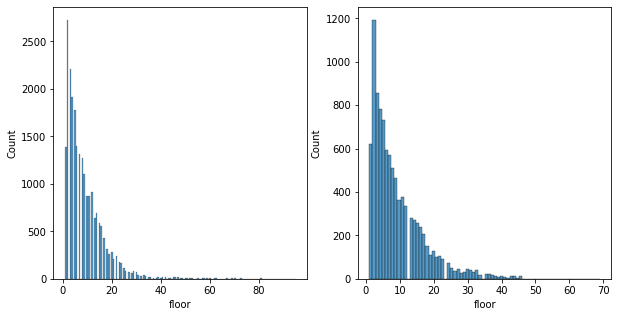

In [21]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
sns.histplot(train.floor, ax=ax[0])
sns.histplot(test.floor, ax=ax[1])
plt.show()

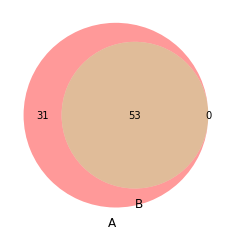

In [22]:
train_floors = set(train.floor.values)
test_floors = set(test.floor.values)
venn2([train_floors, test_floors])
plt.show()

**EDA insight:** While the distribution of the floors are fairly similar, there appear to be more gaps in the training data in the lower floor range (0 - 40). However, as the venn diagram illustrates, the floor numbers in the test set are a subset of the floor numbers in the training set.

### stories

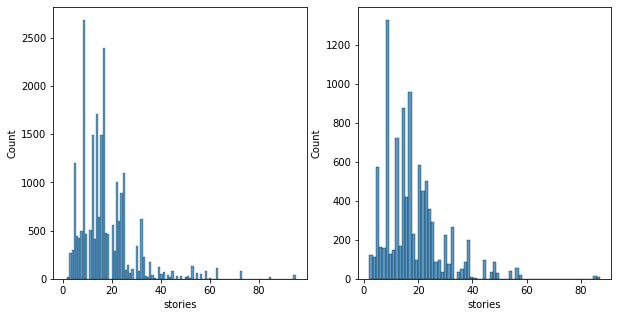

In [23]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
sns.histplot(train.stories, ax=ax[0])
sns.histplot(test.stories, ax=ax[1])
plt.show()

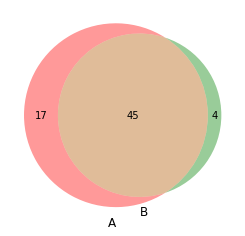

In [24]:
train_stories = set(train.stories.values)
test_stories = set(test.stories.values)
venn2([train_stories, test_stories])
plt.show()

**EDA insight** There are some buildings with a number of stories that are not present in the training set. This could impact the ability of the model to predict the prices accurately since it has never seen similar data.

## Explore pairs and groups of features

In [25]:
def plot_vs(data, feature1, feature2, hue=None, ax=None):
    sns.scatterplot(x=data[feature1], y=data[feature2], hue=data[hue] if hue is not None else None, ax=ax)

def plot_feature_vs_all(data, feature):
    cols = len(data.columns)
    n_rows = n_cols = math.ceil(math.sqrt(cols))
    # Create the subplots
    fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(15,18))
    fig.tight_layout(pad=3.0)
    for i, column in enumerate(data.columns):
        if column in ['address', 'street']: 
            i -= 1
            continue # Skip this to create nicer plots
        plot_vs(data, column, feature, ax=axes[i//n_cols,i%n_cols])

    plt.show()

In this section we explore how the price vary with different features to see if we can learn which features can be important factors for our models. 

First we'll plot a subset of the features against the `log_price`.

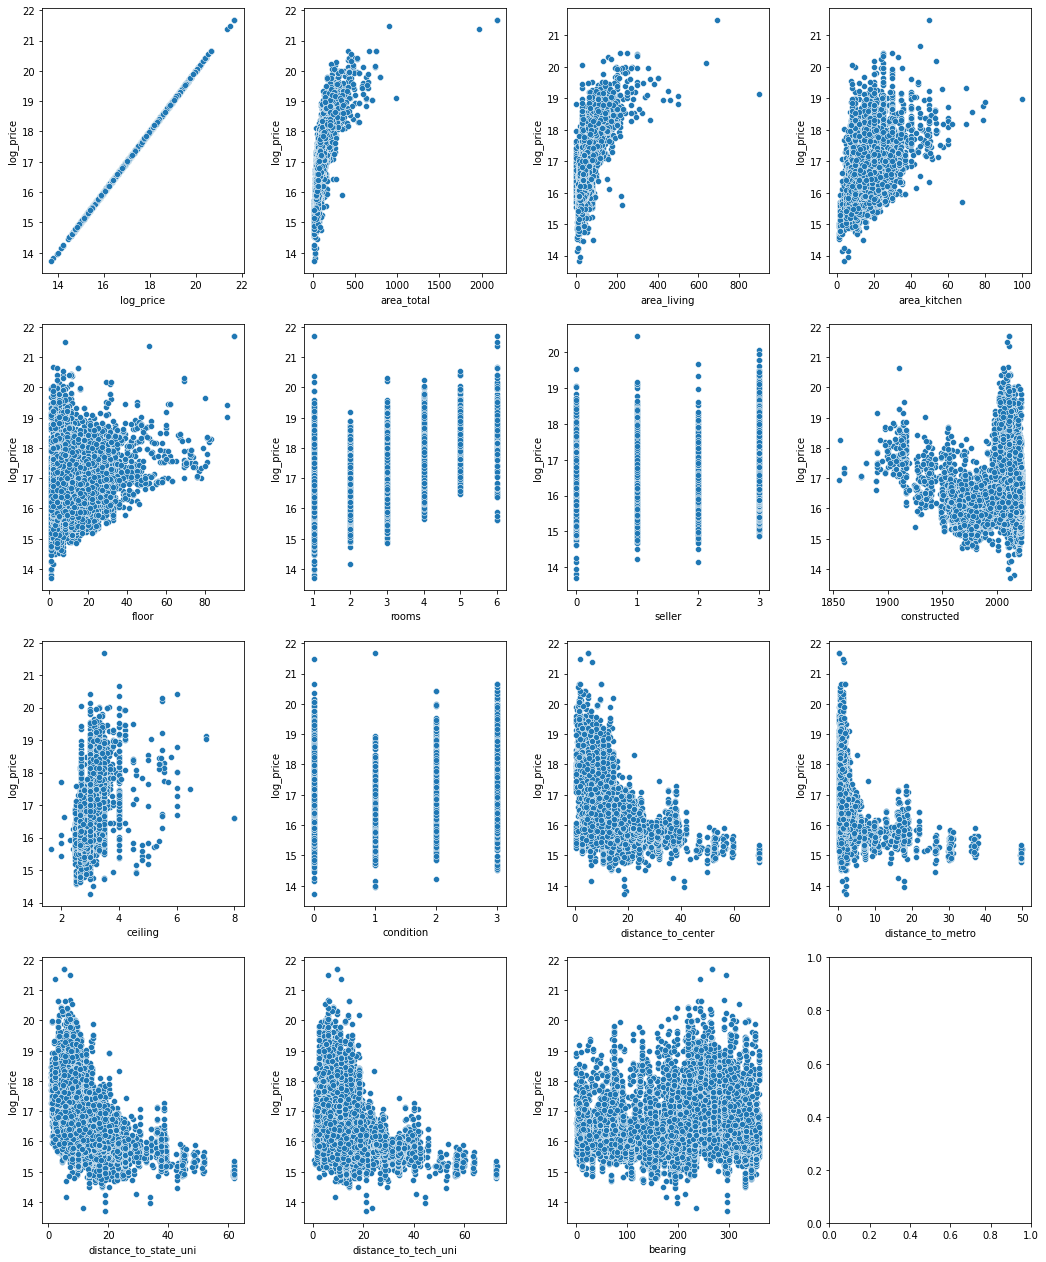

In [26]:
data_to_study = train_with_feats[[
    'log_price',
    'area_total',
    'area_living',
    'area_kitchen',
    'floor',
    'rooms',
    'seller', 
    'constructed',
    'ceiling',
    'condition',
    'distance_to_center',
    'distance_to_metro',
    'distance_to_state_uni',
    'distance_to_tech_uni',
    'bearing',
]]
plot_feature_vs_all(data_to_study, 'log_price')

**EDA insight**: We can see from the plots that all distance metrics negatively affects the price; this makes sense, as distances to facilities is an important factor when selecting an apartment. We also see that `area_total` will be a key factor that our models can take advantage of, since price increases with area -- also intuitive. Finally, we see that some features might not be as advantageous: e.g. `floor` and `bearing`.

Next, we'll take a look at `price_per_m2`

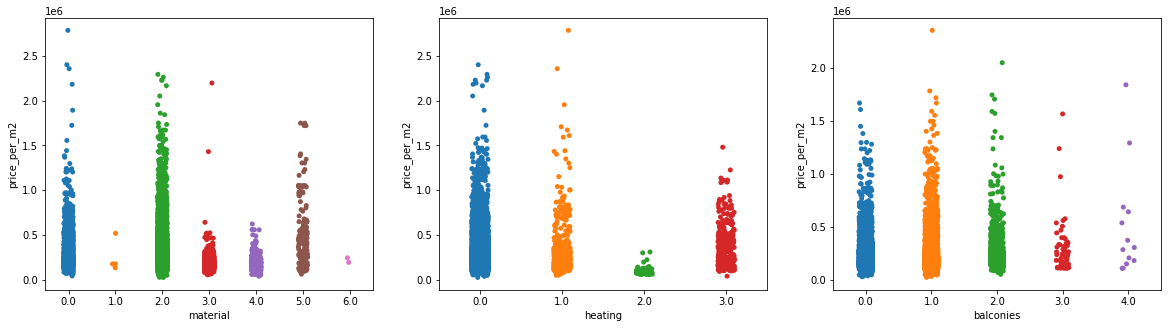

In [27]:
fig, ax = plt.subplots(1, 3, figsize=(20, 5))
sns.stripplot(x="material", y="price_per_m2",  data=train, ax=ax[0])
sns.stripplot(x="heating", y="price_per_m2",  data=train, ax=ax[1])
sns.stripplot(x="balconies", y="price_per_m2",  data=train,  ax=ax[2])
plt.show()

Some categories seem to be on average higher or lower, which can give some useful information. There are however outliers, so there is likely not a huge amount of information to be gained. 

<AxesSubplot:xlabel='distance_to_center', ylabel='area_total'>

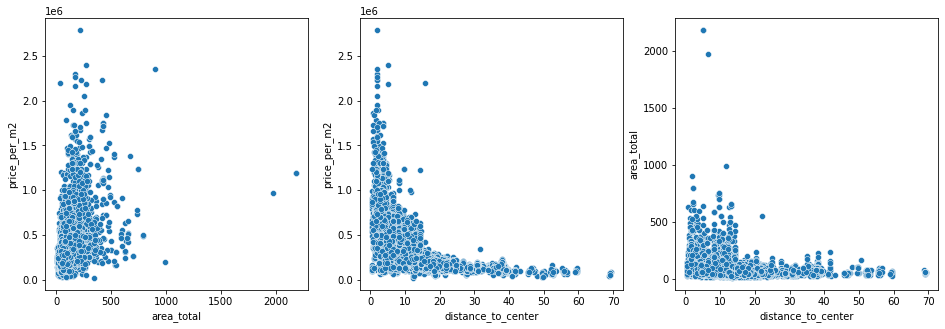

In [28]:
fig, ax =plt.subplots(1,3, figsize=(16,5))
sns.scatterplot(x="area_total", y="price_per_m2", data=train_with_feats, ax=ax[0])
sns.scatterplot(x="distance_to_center", y="price_per_m2", data=train_with_feats, ax=ax[1])
sns.scatterplot(x="distance_to_center", y="area_total", data=train_with_feats, ax=ax[2])

**EDA insight:** The m2 price increases significantly with a shorter distance and indicates a clearer relationship than the price alone. 

### area_total, area_living, and area_kitchen with respect to log_price

<AxesSubplot:xlabel='log_price', ylabel='area_kitchen'>

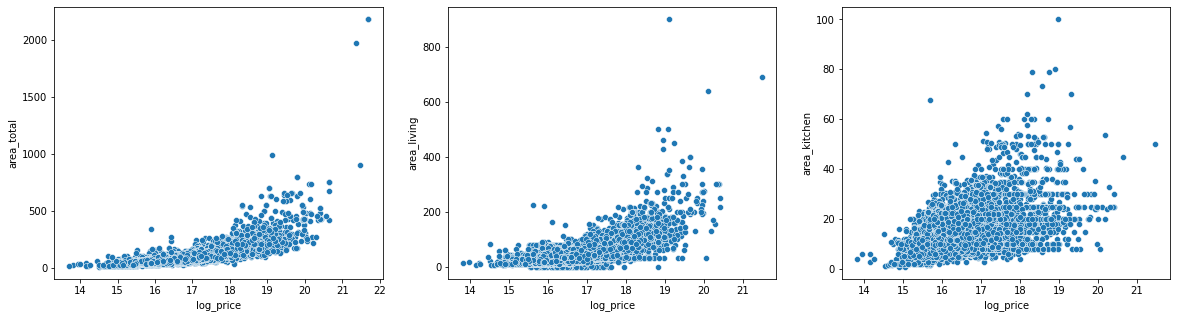

In [29]:
fig, ax = plt.subplots(1, 3, figsize=(20, 5))
sns.scatterplot(x="log_price", y="area_total", data=train_with_feats, ax=ax[0])
sns.scatterplot(x="log_price", y="area_living", data=train_with_feats, ax=ax[1])
sns.scatterplot(x="log_price", y="area_kitchen", data=train_with_feats, ax=ax[2])

**EDA insight**: We can generally observe in all three cases that a greater area correlates with a higher price. However, the picture is not as clear for area_kitchen as there appears to be a lot of variance, which may well be due to the imputation method.

Correlation area_living: 0.7496293729728276


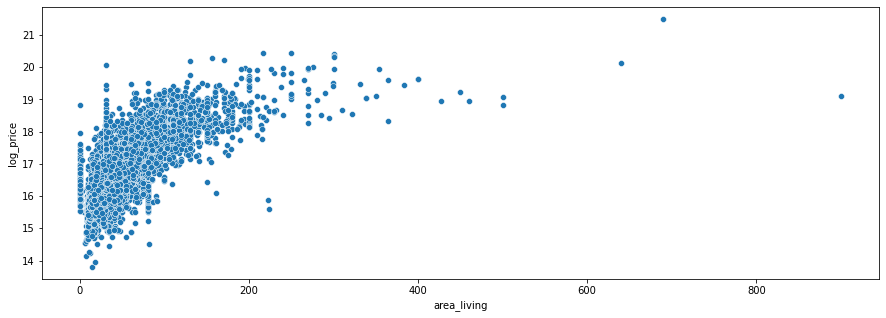

In [30]:
d = train_with_feats.copy()

fig, ax = plt.subplots(figsize=(15, 5))
sns.scatterplot(x="area_living", y="log_price", data=d, ax=ax)
print("Correlation area_living: {}".format(d["area_living"].corr(d["log_price"])))

**EDA insight:** Area living seems to have some values set to zero, which have quite high price. This seems like a mistake, and was corrected further down below. Similar to area_total

In [31]:
train_with_feats.loc[train_with_feats.area_living==0, 'area_living'] = train_with_feats[train_with_feats.area_living==0].area_total * 0.56
test_with_feats.loc[test_with_feats.area_living==0, 'area_living'] = test_with_feats[test_with_feats.area_living==0].area_total * 0.56

### constructed with respect to log_price

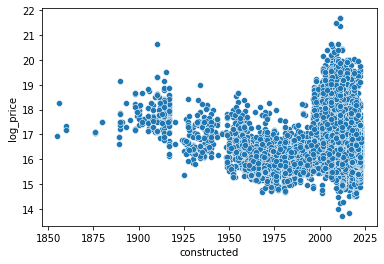

In [32]:
sns.scatterplot(data=train_with_feats, x="constructed", y="log_price")
plt.show()

**EDA insight:** It appears that buildings built after 2000 have a tendency to increase in price the newer they are, while buildings built before 2000 increase in price with age.

### Feature correlation

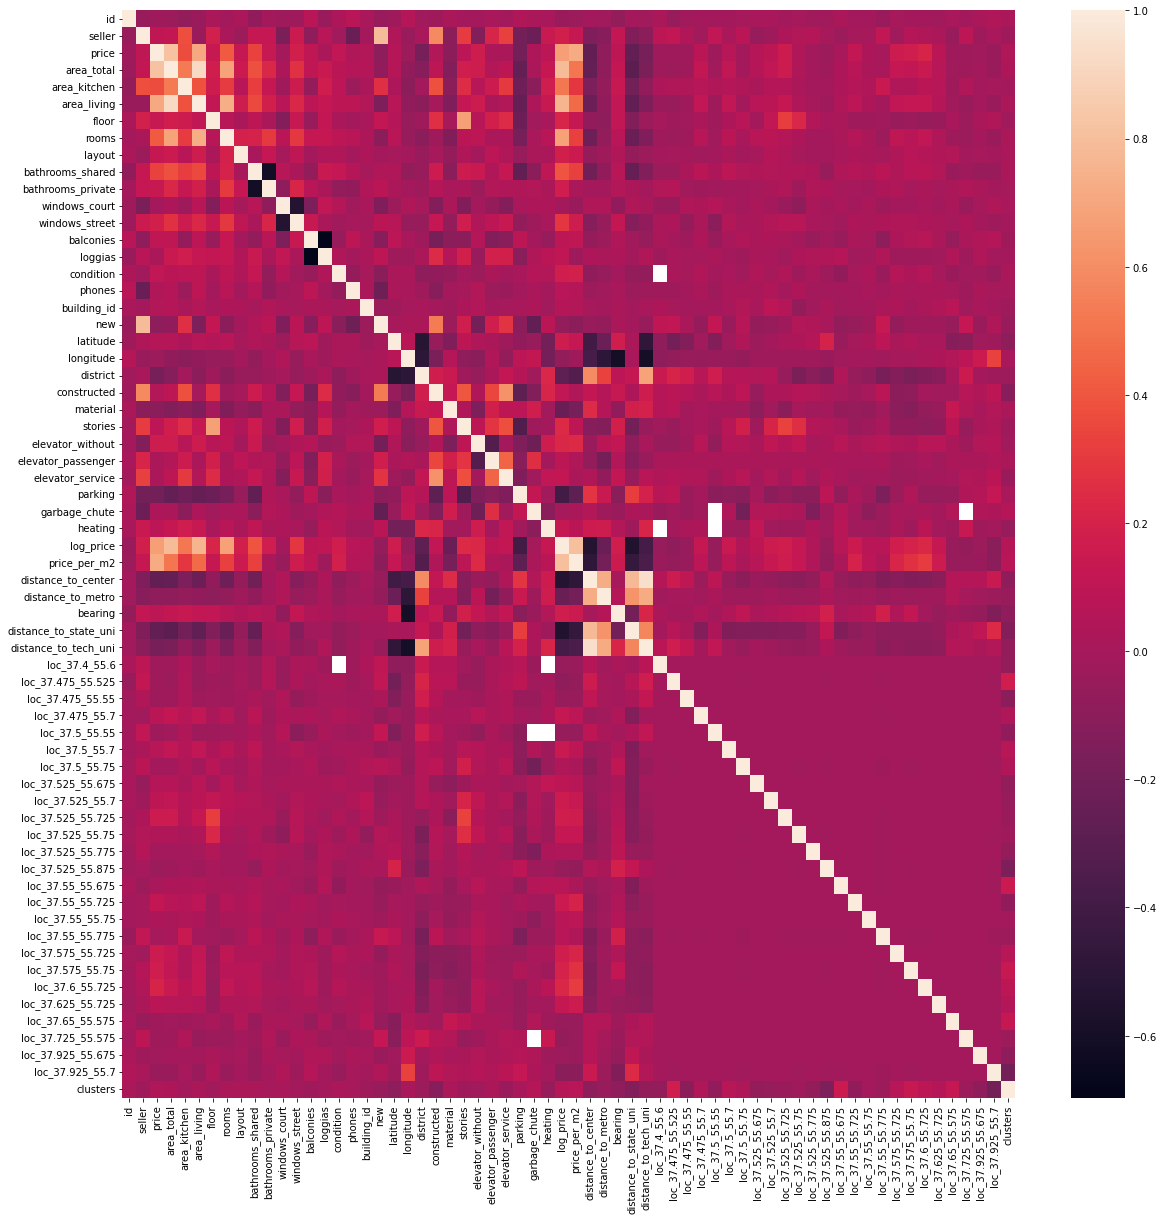

In [33]:
fig, ax = plt.subplots(1, 1, figsize=(20, 20))
sns.heatmap(train_with_feats.corr(), ax=ax)
plt.show()

#### log_price correlation with other features

In [34]:
train_with_feats.corr().abs().sort_values(by="log_price", ascending=False)["log_price"]

log_price                1.000000
price_per_m2             0.801305
area_total               0.782565
area_living              0.755202
rooms                    0.678219
price                    0.664611
distance_to_state_uni    0.549705
distance_to_center       0.534471
area_kitchen             0.517461
bathrooms_shared         0.396012
parking                  0.392306
distance_to_tech_uni     0.390840
windows_street           0.289950
district                 0.282512
distance_to_metro        0.238675
material                 0.235145
stories                  0.233266
loc_37.6_55.725          0.227458
elevator_without         0.224828
floor                    0.212198
loc_37.575_55.75         0.201883
seller                   0.182874
layout                   0.178670
loc_37.575_55.725        0.178068
bearing                  0.177121
loc_37.525_55.725        0.175282
condition                0.173769
bathrooms_private        0.168706
latitude                 0.162631
loc_37.525_55.

**EDA insight:** As expected, the correlation of `area_total` as well as `area_living` are very high. The correlation for `area_kitchen` is a bit lower which may be due to the great variability identified earlier. What is more, `rooms`, `distance_to_state_uni`, `distance_to_center`, `bathrooms_shared`, `parking`, and `distance_to_tech_uni` also have a high correlation with the `log_price`. Albeit some of the categorical features have a lower correlation, this changes after they have been one-hot-encoded as some individual categories (e.g. Central in `district`) have a very high correlation with the price and, thus, will play an important role during prediction.

#### area_total correlation with other features

In [35]:
train_with_feats.corr().abs().sort_values(by="area_total", ascending=False)["area_total"]

area_total               1.000000
area_living              0.914538
price                    0.814829
log_price                0.782565
rooms                    0.683526
area_kitchen             0.529280
price_per_m2             0.511141
bathrooms_shared         0.378500
distance_to_state_uni    0.291657
windows_street           0.265340
parking                  0.259026
distance_to_center       0.257282
bathrooms_private        0.225475
floor                    0.177762
stories                  0.174020
distance_to_tech_uni     0.166054
elevator_without         0.164070
loc_37.525_55.725        0.153699
layout                   0.147221
loc_37.6_55.725          0.144688
loggias                  0.139916
material                 0.138820
heating                  0.130942
district                 0.122858
loc_37.575_55.725        0.121251
loc_37.475_55.7          0.115423
seller                   0.114745
bearing                  0.113099
loc_37.525_55.7          0.110757
loc_37.575_55.

**EDA insight:** As expected, area_total has a very high corrlation with area_living and even rooms. This may cause issues due to multicorrelinearity.

## Clean up features - Data imputation
We imputed all features in the data provided using different approaches for boolean, categorical, and numerical features. 

### Categorical features
In case of categorical features, we simply added a new category for all rows with nans. For instance, in the catgory 'seller', nan values were replaced with category 4 denoting 'other_seller'.

We made an exception for 'windows_street' and 'windows_court' since we cannot assume that all the other buildings don't have any windows to the street or court if this feature contains nans. Hence, we used the bins approach as explained below.

In [36]:
def impute_categorical_features(data):
    data.loc[:, "seller"] = data.loc[:, "seller"].fillna(4)
    data.loc[:, "layout"] = data.loc[:, "layout"].fillna(3)
    data.loc[:, "condition"] = data.loc[:, "condition"].fillna(4)
    data.loc[:, "material"] = data.loc[:, "material"].fillna(7)
    data.loc[:, "parking"] = data.loc[:, "parking"].fillna(3)
    data.loc[:, "heating"] = data.loc[:, "heating"].fillna(4)

### Boolean features
If a boolean feature contained a nan, we generally interpreted it as 'not present', i.e., we set it to 0. 

In [37]:
def impute_boolean_features(data):
    data.loc[:, "elevator_without"] = data.loc[:, "elevator_without"].fillna(0)
    data.loc[:, "elevator_service"] = data.loc[:, "elevator_service"].fillna(0)
    data.loc[:, "elevator_passenger"] = data.loc[:, "elevator_passenger"].fillna(0)
    data.loc[:, "garbage_chute"] = data.loc[:, "garbage_chute"].fillna(0)
    data.loc[:, "balconies"] = data.loc[:, "balconies"].fillna(0)
    data.loc[:, "loggias"] = data.loc[:, "loggias"].fillna(0)

### Numerical features
In case of numerical features, we tried to avoid to simply set it to the mean value as this would probably lead to a distortion of the real data. Instead, we imputed it using bins based on area_total. We computed k bins based on area_total, calculated the mean for a given feature in the corresponding bin, and replaced nans in this range with the computed value.

An exception is constructed. Before imputing it based on bins, we set constructed to 2021 if new was True.

We also tried to impute the data by firstly analysing the correlation of each feature that needs to be imputed with other features. Based on this information, we grouped the data in the training and test set and imputed it with the mean using the features with the highest correlation until all nans were gone. However, performance was slightly worse compared to bins imputation. Hence, we dropped this appraoch for the final model and sticked to bins imputation for numerical features.

In [38]:
def impute_with_bin_mean(data, train_data, test_data, feature, bin_feature, bins=40, decimals=0, verbose=False):
    tr = train_data.copy()
    te = test_data.copy()
    database = pd.concat([tr, te])
    database["bin"], bins = pd.cut(database[bin_feature], bins=40, retbins=True)
    pb = 0
    for b in bins:
        bin_data = database[(database[bin_feature] >= pb) & (database[bin_feature] <= b)]
        bin_mean = bin_data[feature].mean()
        percentage = (bin_mean / bin_data[bin_feature]).mean()
        d = data[(data[bin_feature] >= pb) & (data[bin_feature] <= b)]
        ind = d[d[feature].isna()].index
        if pd.notna(bin_mean) and len(ind) > 0:
            bin_mean = round(bin_mean, decimals)
            data.at[ind, feature] = bin_mean
            if verbose:
                print(
                    "Set {} for {} rows with {} <= {} <= {} to {}".format(feature, len(ind), pb, bin_feature, b, bin_mean))
        pb = b

In [39]:
def impute_numerical_features(data):
    data.loc[data.new == 1, "constructed"] = data.loc[data.new == 1, "constructed"].fillna(2021)
    impute_with_bin_mean(data=data, train_data=train, test_data=test, feature="constructed", bins=12, bin_feature="district")
    data.loc[data.constructed >= 2021, "new"] = data.loc[data.constructed >= 2021, "new"].fillna(1)
    data.loc[data.constructed < 2021, "new"] = data.loc[data.constructed < 2021, "new"].fillna(0)
    
    numerical_features = ["phones", "ceiling", "bathrooms_shared", "bathrooms_private", "windows_street", "windows_court", "area_kitchen", "area_living"]
    for num_feat in numerical_features:
        impute_with_bin_mean(data=data, train_data=train, test_data=test, feature=num_feat, bin_feature="area_total", bins=20)
        fill_value = data[data[num_feat].notna()][num_feat].mean(axis=0).round()
        data.loc[:, num_feat] = data.loc[:, num_feat].fillna(fill_value)
    

In [40]:
def impute_nans(data):
    impute_categorical_features(data)
    impute_boolean_features(data)
    impute_numerical_features(data)

train_data = train_with_feats.copy()
test_data = test_with_feats.copy()
impute_nans(train_data)
impute_nans(test_data)

# Feature Engineering
The new features that we added were explained extensively above in the section 'domain knowledge'. In addition to that, we also performed a log transformation of the price and computed the price per square meter as this improved model performance significantly.

## One-hot encoding categorical features
We one-hot encoded all categorical features and dropped the original feature.

In [41]:
district_categories = {
    3: "East",
    6: "South-West",
    5: "South",
    4: "South-East",
    0: "Central",
    2: "North-East",
    1: "North",
    8: "North-West",
    7: "West",
    11: "Novomoskovsk",
    10: "Troitsk",
    9: "Zelenograd",
    12: "Other_district"
}
material_categories = {
    0: "Bricks",
    1: "Wood",
    2: "Monolith",
    3: "Panel",
    4: "Block",
    5: "Monolithic_brick",
    6: "Stalin_project",
    7: "Other_material"
}
heating_categories = {
    0: "Central",
    1: "Individual",
    2: "Boiler",
    3: "Autonomous_boiler",
    4: "Other_heating"
}
parking_categories = {
    0: "Ground",
    1: "Underground",
    2: "Multilevel",
    3: "No_parking"
}
seller_categories = {
    0: "Owner",
    1: "Company",
    2: "Agents",
    3: "Developer",
    4: "Other_seller"
}
layout_categoires = {
    0: "Adjacent",
    1: "Isolated",
    2: "Adjacent_isolated",
    3: "Other_layout"
}
condition_categories = {
    0: "Undecorated",
    1: "Decorated",
    2: "Euro_repair",
    3: "Special_design",
    4: "Other_condition"
}
categorical_features = {
    "parking": parking_categories,
    "heating": heating_categories,
    "material": material_categories,
    "district": district_categories,
    "seller": seller_categories,
    "layout": layout_categoires,
    "condition": condition_categories
}

In [42]:
def one_hot_encode_categorical_features(data, remove_org=True):
    for orig_feat, categories in categorical_features.items():
        for k, category in categories.items():
            data[category] = (data[orig_feat] == k).astype(int)
        if remove_org:
            data.drop(orig_feat, axis=1, inplace=True)
one_hot_encode_categorical_features(train_data)
one_hot_encode_categorical_features(test_data)

# Outliers

## Min-Max Outliers
We analysed the test data with respect to the min and max values of each feature. If a row in the train data contains a value in one of the features that is greater than the min or max value, we removed the row from the training data.

In [43]:
def remove_min_max_outliers(train_data, test_data, features):
    t = train_data.copy()
    test_feat_min_max = pd.DataFrame({"max": test_data.describe().loc["max"], "min": test_data.describe().loc["min"]}).T
    for feature in features:
        max_val = test_feat_min_max[feature]["max"]
        min_val = test_feat_min_max[feature]["min"]
        max_ind = t[t[feature] > max_val].index
        min_ind = t[t[feature] < min_val].index
        t.drop(max_ind, inplace=True)
        t.drop(min_ind, inplace=True)

    print("Samples before: {} | Samples after: {}".format(len(train_data), len(t)))
    return t
relevant_outlier_columns = test_data.columns.drop(["id", "building_id", "street", "address", "price", "log_price", "price_per_m2", "street", "address"], errors="ignore")
train_data = remove_min_max_outliers(train_data, test_data, relevant_outlier_columns)

Samples before: 23285 | Samples after: 23062


In [44]:
train_data = train_data.reset_index()

# Model Definition, Training, and Prediction

## Feature selection
Selecting the features that should be part of the training set.

In [45]:
# features for first model
features = train_data.columns
features = features.drop(["id", "building_id", "street", "address", "price", "log_price", "price_per_m2", "street", "address", 'index'], errors="ignore")
features = features.drop([col for col in train_data.columns if col[0:2] == 'cl']) 

# features for second model
features_2 = train_data.columns
features_2 = features.drop(["id", "building_id", "street", "address", "price", "log_price", "price_per_m2", "street", "address", 'index'], errors="ignore")
features_2 = features.drop([col for col in train_data.columns if col[0:3] == 'loc']) 

In [46]:
def root_mean_squared_log_error(y_true, y_pred):
    return np.sqrt(mean_squared_log_error(y_true, y_pred))

## Model 1 - Stacking using averaging and box_areas
Our first model comprises LGBMRegressor, CatBoostRegressor, and a BaggingRegressor. We initially optimised the models using cross-validation to find the best hyperparameters. We saved the obtained scores of each model as this is required for the prediction to work. Thereafter, we trained the base models on the entire training set, predicted the prices of the test set with each model, and computed the weighted average with the weights based on the scores obtained in cross-validation.

The data in cross validation is split based on building_id in order for the results to be closer to the scores we can expect from the test set.

### Training

In [47]:


# Overload of BagginRegressor to store feature_importances_
# From https://stackoverflow.com/questions/44333573/feature-importances-bagging-scikit-learn
class myBaggingRegressor(BaggingRegressor):
    def fit(self, X, y):
        fitd = super().fit(X, y)
        # need to pad features?
        if self.max_features == 1.0:
            # compute feature importances or coefficients
            if hasattr(fitd.estimators_[0], 'feature_importances_'):
                self.feature_importances_ =  np.mean([est.feature_importances_ for est in fitd.estimators_], axis=0)
            else:
                self.coef_ =  np.mean([est.coef_ for est in fitd.estimators_], axis=0)
                self.intercept_ =  np.mean([est.intercept_ for est in fitd.estimators_], axis=0)
        else:
            # need to process results into the right shape
            coefsImports = np.empty(shape=(self.n_features_, self.n_estimators), dtype=float)
            coefsImports.fill(np.nan)
            if hasattr(fitd.estimators_[0], 'feature_importances_'):
                # store the feature importances
                for idx, thisEstim in enumerate(fitd.estimators_):
                    coefsImports[fitd.estimators_features_[idx], idx] = thisEstim.feature_importances_
                # compute average
                self.feature_importances_ = np.nanmean(coefsImports, axis=1)
            else:
                # store the coefficients & intercepts
                self.intercept_ = 0
                for idx, thisEstim in enumerate(fitd.estimators_):
                    coefsImports[fitd.estimators_features_[idx], idx] = thisEstim.coefs_
                    self.intercept += thisEstim.intercept_
                # compute
                self.intercept /= self.n_estimators
                # average
                self.coefs_ = np.mean(coefsImports, axis=1)                
        return fitd



In [48]:
SEED = 42
model1 = lgbm.LGBMRegressor(
    random_state=SEED,
    learning_rate=0.1,
    n_estimators=2000,
    boosting_type='gbdt',
    n_jobs=2,
    num_leaves=20,
    min_data_in_leaf=12,
    max_depth=20,
    max_bin=160,
)

model2 = CatBoostRegressor(
    n_estimators=1000,
    learning_rate=0.2,
    thread_count=2,
    depth=7,    
    min_data_in_leaf=10,
    silent=True,
    random_seed=SEED,
)

model3 = BaggingRegressor(
    n_estimators=200,
    n_jobs=2,
    random_state=SEED,
    max_features=0.7,
    max_samples=0.8,
)



In [49]:
def cross_validation(model, k, data, features, target_feature):
    """Splits based on building id"""
    kf = KFold(
        n_splits=k,
        shuffle=True,
        random_state=SEED
    )
    train_scores = []
    val_scores = []
    
    for i, (train_index, test_index) in tqdm(enumerate(kf.split(buildings_train)), total=k):
        building_val_ids = buildings_train.id.values[test_index]
        train = data[~data.building_id.isin(building_val_ids)]
        val = data[data.building_id.isin(building_val_ids)]
        X_train = train[features].values
        X_val = val[features].values
        y_train = train[[target_feature]].values.ravel()
        y_val = val[[target_feature]].values.ravel()
        y_train_true = train[["price"]].values.ravel()
        y_val_true = val[["price"]].values.ravel()

        model.fit(X_train, y_train)
        train_pred = model.predict(X_train)
        val_pred = model.predict(X_val)
        
        if target_feature == "log_price":
            train_pred = (np.e ** train_pred) - 1
            val_pred = (np.e ** val_pred) - 1
        elif target_feature == "price_per_m2":
            train_pred = train_pred * train.area_total
            val_pred = val_pred * val.area_total
        else:
            raise Exception("Unknown target feature")
            
        train_rsmle = root_mean_squared_log_error(y_true=y_train_true, y_pred=train_pred)
        val_rsmle = root_mean_squared_log_error(y_true=y_val_true, y_pred=val_pred)
        train_scores.append(train_rsmle)
        val_scores.append(val_rsmle)
    train_scores = np.array(train_scores)
    val_scores = np.array(val_scores)
    print("Train rsmle: {} | Std: {}".format(train_scores.mean(), train_scores.std()))
    print("Val rsmle: {} | Std: {}".format(val_scores.mean(), val_scores.std()))
    return val_scores.mean()

In [50]:
model1_scores = cross_validation(model1, 5, train_data, features, "log_price")
model2_scores = cross_validation(model2, 5, train_data, features, "log_price")
model3_scores = cross_validation(model3, 5, train_data, features, "price_per_m2")
scores = {
    "lgbm": model1_scores,
    "cb": model2_scores,
    "bagging": model3_scores,
}

  0%|                                                                                                                             | 0/5 [00:00<?, ?it/s]

[LightGBM] [Warning] min_data_in_leaf is set=12, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=12


 20%|███████████████████████▍                                                                                             | 1/5 [00:05<00:21,  5.37s/it]

[LightGBM] [Warning] min_data_in_leaf is set=12, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=12


 40%|██████████████████████████████████████████████▊                                                                      | 2/5 [00:10<00:16,  5.49s/it]

[LightGBM] [Warning] min_data_in_leaf is set=12, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=12


 60%|██████████████████████████████████████████████████████████████████████▏                                              | 3/5 [00:16<00:11,  5.56s/it]

[LightGBM] [Warning] min_data_in_leaf is set=12, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=12


 80%|█████████████████████████████████████████████████████████████████████████████████████████████▌                       | 4/5 [00:22<00:05,  5.55s/it]

[LightGBM] [Warning] min_data_in_leaf is set=12, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=12


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:27<00:00,  5.44s/it]


Train rsmle: 0.041808799746083994 | Std: 0.0009047738669908493
Val rsmle: 0.20045835791906946 | Std: 0.024160568648408258


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:44<00:00,  8.85s/it]


Train rsmle: 0.05190201949638736 | Std: 0.0005239324028882044
Val rsmle: 0.20810814918510867 | Std: 0.027394963664114393


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [01:57<00:00, 23.53s/it]

Train rsmle: 0.06268347548318608 | Std: 0.001162227688456011
Val rsmle: 0.20962261090951104 | Std: 0.032775235707229344


In [51]:
model_scores = pd.DataFrame(scores, index=[0])
model_scores = model_scores.T
model_scores.columns = ["rsmle"]
model_scores

,rsmle
lgbm,0.200458
cb,0.208108
bagging,0.209623


### Model interpretation
To get a closer look at how our model predicts on unseen data, we will inspect which features the model prioritizes. To do this, we will look at the feature importance of the models. Feature importance tells us how important the different features are to the model, i.e. how much the feature is weighted during prediction.

#### lgbm

In [74]:
lgbm_feat_imp = pd.DataFrame({
    "features": features,
    "importance": model1.feature_importances_,
})
lgbm_feat_imp["normalised"] = (lgbm_feat_imp.importance - lgbm_feat_imp.importance.min()) / (lgbm_feat_imp.importance.max() - lgbm_feat_imp.importance.min())

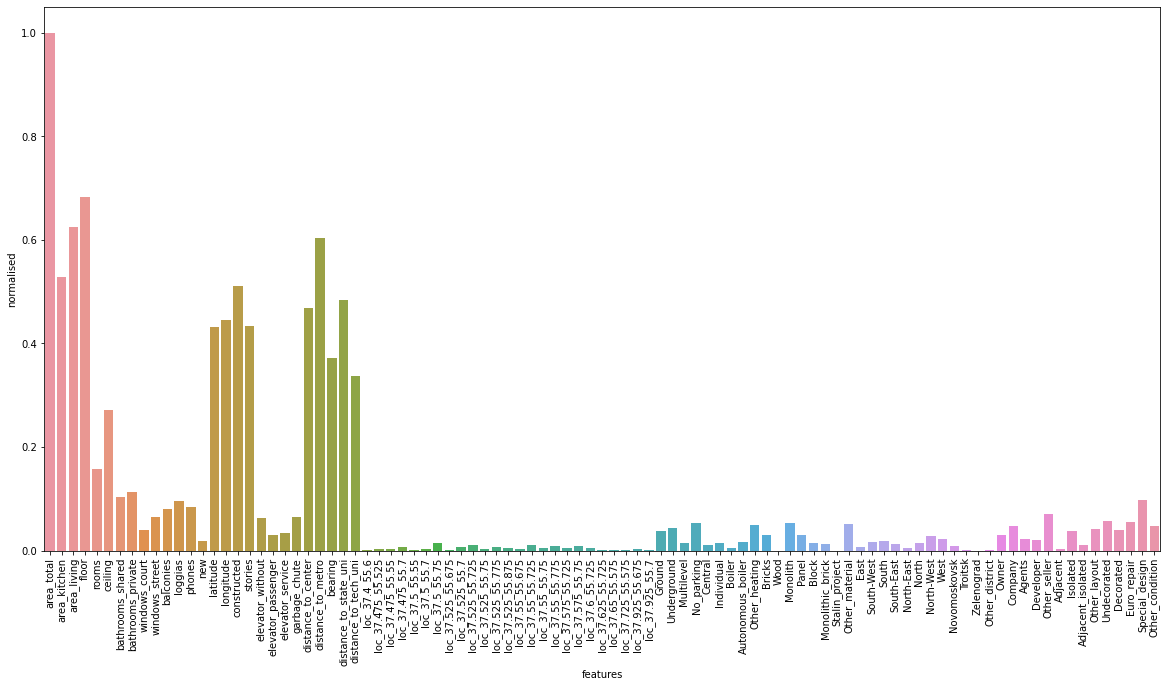

In [75]:
plt.figure(figsize=(20, 10))
ax = sns.barplot(data=lgbm_feat_imp, x="features", y="normalised")
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
plt.show()

In [76]:
lgbm_feat_imp[lgbm_feat_imp.normalised > 0.4].T

,0,1,2,3,14,15,16,17,22,23,25
features,area_total,area_kitchen,area_living,floor,latitude,longitude,constructed,stories,distance_to_center,distance_to_metro,distance_to_state_uni
importance,4034,2131,2519,2753,1741,1800,2065,1749,1891,2439,1955
normalised,1.0,0.52826,0.624442,0.682449,0.431582,0.446207,0.511899,0.433565,0.468765,0.604611,0.484631


**Insight:** As we can see from the plot of the most important features as well as the table above, area_total, area_living, as well as area_kitchen played an important role in lightGBM, while the box_areas only played a small role. Some of the custom features, such as the distance to the metro and to the universities, were also used quite a lot and, thus, benefitted the model. 

In [77]:
lgbm_feat_imp[lgbm_feat_imp.normalised == 0].T

,62,67,79
features,Wood,Stalin_project,Zelenograd
importance,0,0,0
normalised,0.0,0.0,0.0


**Insight:** While there are several features with a relatively low importance, e.g. the box areas, removing them would certainly affect the model as they played a role in some of the estimators. However, three features were not used at all, that is, Wood, Stalin_project, and the district Zelenograd. These could be removed without affecting model performance at all.

#### catboost

In [71]:
cb_feat_imp = pd.DataFrame({
    "features": features,
    "importance": model2.feature_importances_,
})
cb_feat_imp["normalised"] = (cb_feat_imp.importance - cb_feat_imp.importance.min()) / (cb_feat_imp.importance.max() - cb_feat_imp.importance.min())

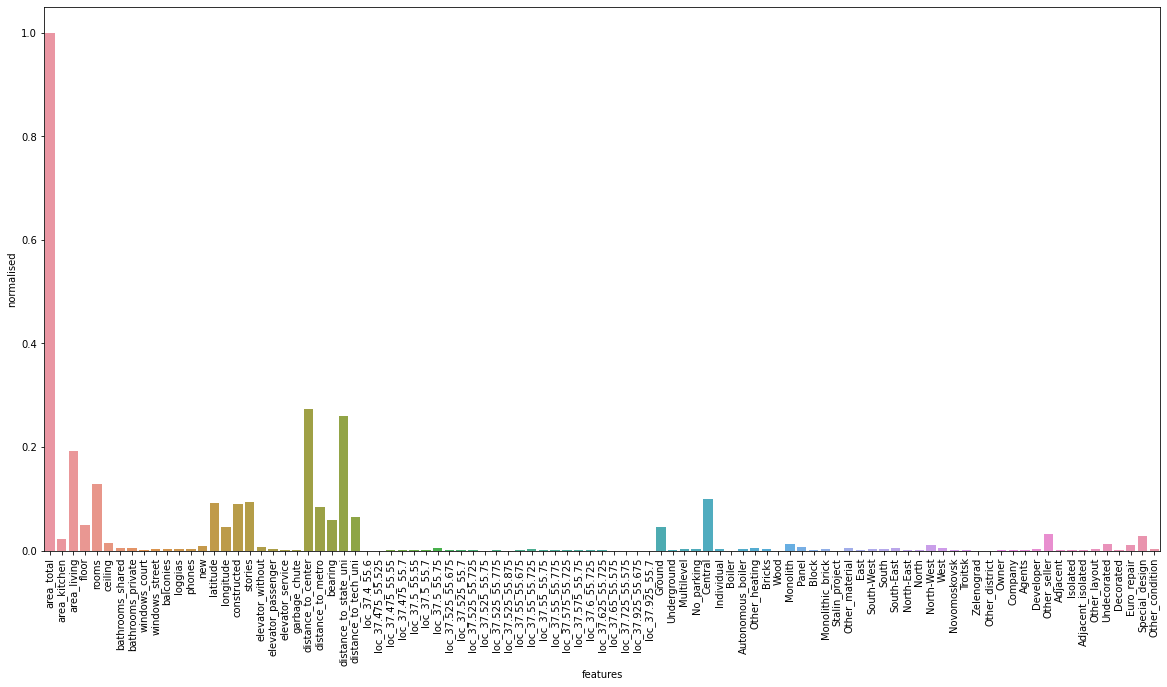

In [72]:
plt.figure(figsize=(20, 10))
ax = sns.barplot(data=cb_feat_imp, x="features", y="normalised")
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
plt.show()

**insight:** Obviously, the most important feature to catboost was area_total, while distance_to_center as well as the distance to the state university also played an important role. However, the remaining features were apparently less important, which interesting. We tried to remove some of the features with a lower importance in order to see the impact on the model and the performance decreased significantly, showing that even features with a low importance affect model performance positively.

In [73]:
cb_feat_imp[cb_feat_imp.normalised == 0].T

,51,79
features,loc_37.925_55.7,Zelenograd
importance,0.0,0.0
normalised,0.0,0.0


**insight:** Still, two features had an importance of 0, namely loc_37.925_55.7 as well as the district Zelenograd. These could be removed without affecting the model at all.

#### bagging
We could not conduct a thorough investigation of the bagging model with respect to feature importance since we set the parameter `max_features` to 0.7. Thus, the features will be different for every decision tree, which makes it difficult to analyse feature importance.

Generally speaking, we can conclude that the most important feature across all models was area_total. The models could probably be improved by adding new features that are somehow based on or related to area_total.

### Prediction using model 1

In [49]:
model1.fit(train_data[features], train_data["log_price"])
model2.fit(train_data[features], train_data["log_price"])
model3.fit(train_data[features], train_data["price_per_m2"])

model1_pred = model1.predict(test_data[features])
model2_pred = model2.predict(test_data[features])
model3_pred = model3.predict(test_data[features])

model1_pred = (np.e ** model1_pred) - 1
model2_pred = (np.e ** model2_pred) - 1
model3_pred *= test_data.area_total

predictions = [model1_pred, model2_pred, model3_pred]
pred = np.average(predictions, 
    weights = 1 / model_scores['rsmle'] ** 4,
    axis=0
)
submission = pd.DataFrame()
submission['id'] = test_data.id
submission['price_prediction'] = pred
submission.to_csv('submission.csv', index=False)

[LightGBM] [Warning] min_data_in_leaf is set=12, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=12


## Model 2 - Stacking using averaging and clusters instead of box_areas

In our second model, we used clusters instead of box_areas since the box_areas had generally a lower correlation than the clusters as seen above.

### Cross Validation

In [78]:
model1_scores = cross_validation(model1, 5, train_data, features_2, "log_price")
model2_scores = cross_validation(model2, 5, train_data, features_2, "log_price")
model3_scores = cross_validation(model3, 5, train_data, features_2, "price_per_m2")
scores = {
    "lgbm": model1_scores,
    "cb": model2_scores,
    "bagging": model3_scores,
}

  0%|                                                                                                                             | 0/5 [00:00<?, ?it/s]

[LightGBM] [Warning] min_data_in_leaf is set=12, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=12


 20%|███████████████████████▍                                                                                             | 1/5 [00:05<00:20,  5.13s/it]

[LightGBM] [Warning] min_data_in_leaf is set=12, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=12


 40%|██████████████████████████████████████████████▊                                                                      | 2/5 [00:09<00:14,  4.86s/it]

[LightGBM] [Warning] min_data_in_leaf is set=12, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=12


 60%|██████████████████████████████████████████████████████████████████████▏                                              | 3/5 [00:15<00:10,  5.20s/it]

[LightGBM] [Warning] min_data_in_leaf is set=12, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=12


 80%|█████████████████████████████████████████████████████████████████████████████████████████████▌                       | 4/5 [00:21<00:05,  5.72s/it]

[LightGBM] [Warning] min_data_in_leaf is set=12, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=12


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:28<00:00,  5.70s/it]


Train rsmle: 0.0414840003856545 | Std: 0.0008493290438937845
Val rsmle: 0.20162882370032315 | Std: 0.023066693840847252


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:50<00:00, 10.03s/it]


Train rsmle: 0.05107645340385055 | Std: 0.0007466598458820928
Val rsmle: 0.20401177052180106 | Std: 0.0171302722018338


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [01:45<00:00, 21.00s/it]

Train rsmle: 0.06291393772668163 | Std: 0.0011826037975309043
Val rsmle: 0.20950284543075665 | Std: 0.032674747081997545


In [79]:
model_scores = pd.DataFrame(scores, index=[0])
model_scores = model_scores.T
model_scores.columns = ["rsmle"]
model_scores

,rsmle
lgbm,0.201629
cb,0.204012
bagging,0.209503


### model interpretation

#### lgbm

In [81]:
lgbm_feat_imp = pd.DataFrame({
    "features": features_2,
    "importance": model1.feature_importances_,
})
lgbm_feat_imp["normalised"] = (lgbm_feat_imp.importance - lgbm_feat_imp.importance.min()) / (lgbm_feat_imp.importance.max() - lgbm_feat_imp.importance.min())

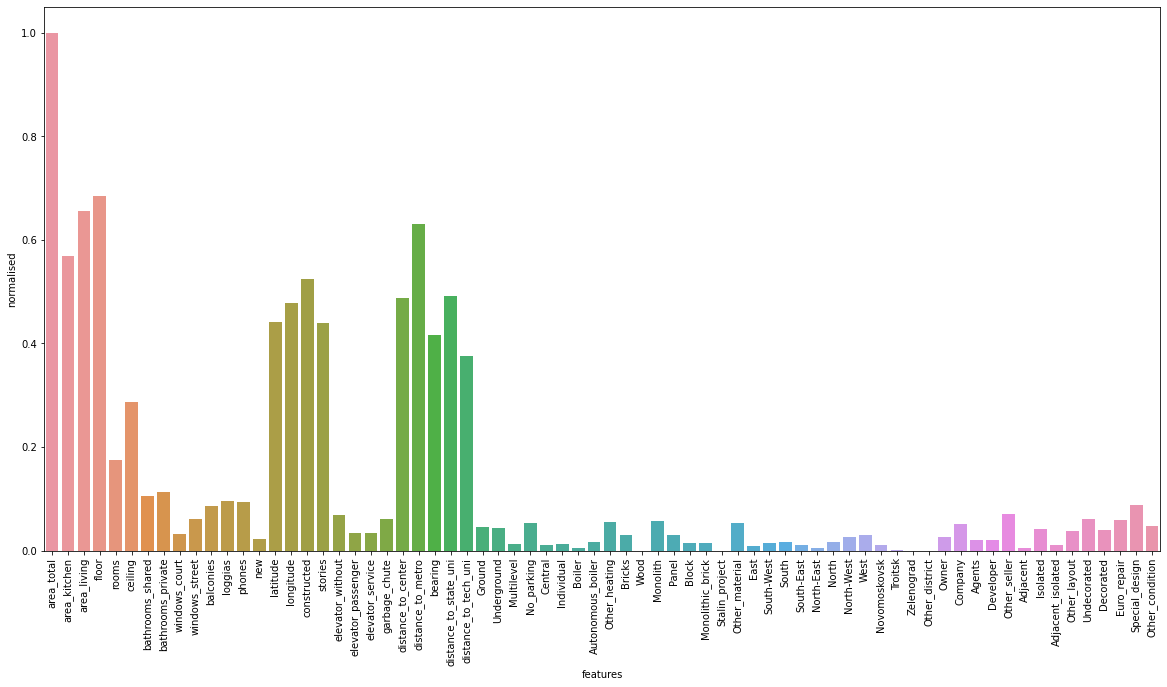

In [82]:
plt.figure(figsize=(20, 10))
ax = sns.barplot(data=lgbm_feat_imp, x="features", y="normalised")
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
plt.show()

In [83]:
lgbm_feat_imp[lgbm_feat_imp.normalised == 0].T

,37,42,54,55
features,Wood,Stalin_project,Zelenograd,Other_district
importance,0,0,0,0
normalised,0.0,0.0,0.0,0.0


**insight:** Unsurprisingly, the results are fairly similar to the results obtained with the first model, with area_total, area_living, and area_kitchen being most important to the model. The major difference is that the box_area features are gone, leading to an increase in important in some features. In constrast to the first model, four features have an importance equivalent to 0 instead of just three. 

#### catboost

In [84]:
cb_feat_imp = pd.DataFrame({
    "features": features_2,
    "importance": model2.feature_importances_,
})
cb_feat_imp["normalised"] = (cb_feat_imp.importance - cb_feat_imp.importance.min()) / (cb_feat_imp.importance.max() - cb_feat_imp.importance.min())

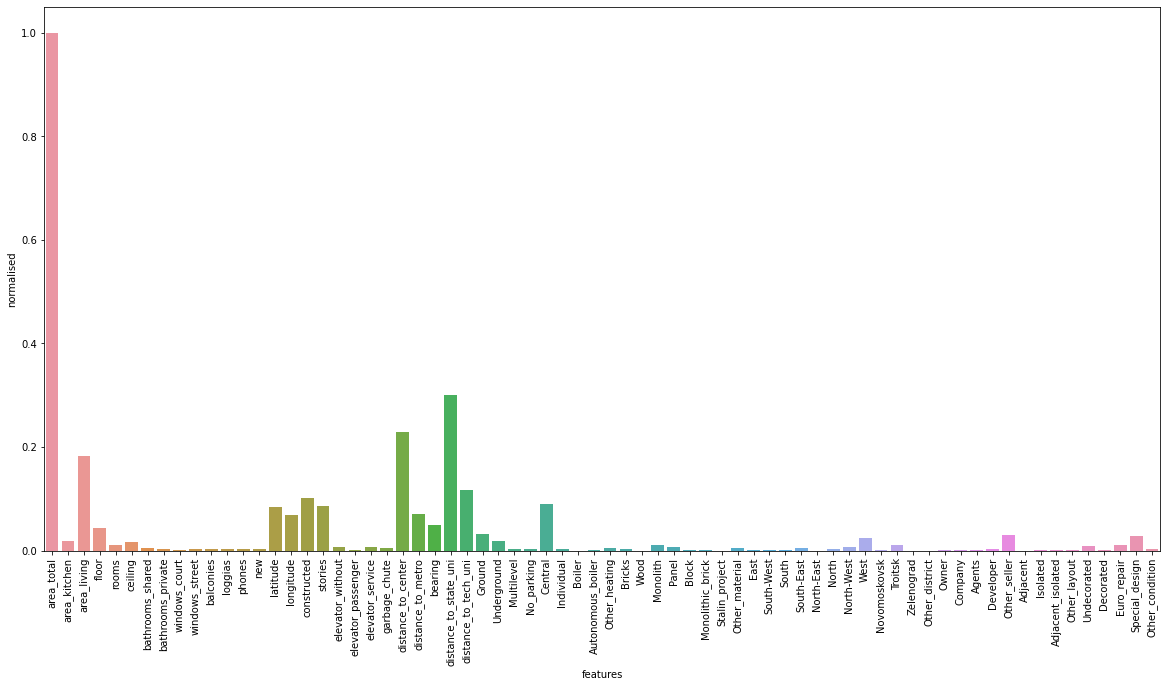

In [85]:
plt.figure(figsize=(20, 10))
ax = sns.barplot(data=cb_feat_imp, x="features", y="normalised")
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
plt.show()

In [86]:
cb_feat_imp[cb_feat_imp.normalised == 0].T

,54
features,Zelenograd
importance,0.0
normalised,0.0


**insight** Similar to the first appraoch, the feature importances of the second model have not really changed except for the removal of the box areas. area_total is still the most important feature, followed by distance_to_state_uni and distance_to_center.
Contrary to lgbm, Zelenograd is (after the removal of the box areas) still the only feature that could be removed without affecting model performance.

### Prediction using model 2

In [ ]:
model1.fit(train_data[features_2], train_data["log_price"])
model2.fit(train_data[features_2], train_data["log_price"])
model3.fit(train_data[features_2], train_data["price_per_m2"])

model1_pred = model1.predict(test_data[features_2])
model2_pred = model2.predict(test_data[features_2])
model3_pred = model3.predict(test_data[features_2])

model1_pred = (np.e ** model1_pred) - 1
model2_pred = (np.e ** model2_pred) - 1
model3_pred *= test_data.area_total

predictions = [model1_pred, model2_pred, model3_pred]
pred = np.average(predictions, 
    weights = 1 / model_scores['rsmle'] ** 4,
    axis=0
)
submission = pd.DataFrame()
submission['id'] = test_data.id
submission['price_prediction'] = pred
submission.to_csv('submission_2.csv', index=False)

## Model 3 - Stacking using meta model
In our third model, we replaced the averaing step of model 1 with a meta model that tries to minimize the prediction errors of the base models. Sadly, despite our best efforts, our third model was performing worse than the first and second model even though we tried various base models and optimization techniques. We skipped the model interpretation in this part since this is not our primary model that we used for obtaining the selected scores on kaggle. We just included it to show all our approaches.

### Training of the base models

In [50]:
def custom_cv(data, building_data, k):
    kf = KFold(
        n_splits=k,
        shuffle=True,
        random_state=SEED
    )
    inds = [ind for i, ind in enumerate(kf.split(building_data))]
    i = 0
    while i < len(inds):
        building_val_ids = building_data.id.values[inds[i][1]]
        train_ids = data[~data.building_id.isin(building_val_ids)].index.values
        val_ids = data[data.building_id.isin(building_val_ids)].index.values
        yield (train_ids, val_ids)
        i += 1

In [51]:
def train_val_split(data, buildings_data, features, target, ratio=0.2):
    sample_count = round(0.2 * buildings_data.shape[0])
    buildings_val = buildings_data.sample(sample_count)
    buildings_train_data = buildings_data[~buildings_data.id.isin(buildings_val.id)]
    X_train = data[~data.building_id.isin(buildings_val.id)]
    X_val = data[data.building_id.isin(buildings_val.id)]
    return X_train, X_val, buildings_train_data

In [52]:
X_train, X_val, buildings_train_data = train_val_split(train_data, buildings_train, f, "log_price")

In [53]:
def get_oof(clf, x_train, x_test, features, target, buildings_train_data):
    """
    Popular function on Kaggle.
    
    Trains a classifier on 4/5 of the training data and
    predicts the rest (1/5). This procedure is repeated for all 5 folds,
    thus we have predictions for all training set. This prediction is one
    column of meta-data, later on used as a feature column by a meta-algorithm.
    We predict the test part and average predictions across all 5 models.
    
    Keyword arguments:
    clf -- classifier
    x_train -- 4/5 of training data
    y_train -- corresponding labels
    x_test -- all test data
    
    """
    ntrain = x_train.shape[0]
    ntest = x_test.shape[0]
    oof_train = np.zeros((ntrain,))
    oof_test = np.zeros((ntest,))
    oof_test_skf = np.empty((5, ntest))
    x_train = x_train.reset_index()
    x_test = x_test.reset_index()

    
    for i, (train_index, test_index) in tqdm(enumerate(custom_cv(x_train, buildings_train_data, 5)), total=5):
        x_tr = x_train.loc[train_index, features]
        y_tr = x_train.loc[train_index, target]
        x_te = x_train.loc[test_index, features]

        clf.fit(x_tr, y_tr)
        oof_train[test_index] = clf.predict(x_te)
        oof_test_skf[i, :] = clf.predict(x_test[features])

    oof_test[:] = oof_test_skf.mean(axis=0)
    return oof_train.reshape(-1, 1), oof_test.reshape(-1, 1)

In [54]:
def ensemble_predict(models, meta_model, X):
    meta_prediction = np.zeros((X.shape[0], len(models)))
    for i, model in enumerate(models):
        meta_prediction[:, i] = model.predict(X)
    return meta_model.predict(meta_prediction)

In [55]:
from sklearn.ensemble import GradientBoostingRegressor

base_model1 = lgbm.LGBMRegressor(
    random_state=SEED,
    learning_rate=0.1,
    n_estimators=2000,
    boosting_type='gbdt',
    n_jobs=2,
    num_leaves=20,
    min_data_in_leaf=12,
    max_depth=20,
    max_bin=160,
)

base_model2 = CatBoostRegressor(
    n_estimators=1000,
    learning_rate=0.2,
    thread_count=2,
    depth=7,    
    min_data_in_leaf=10,
    silent=True,
    random_seed=SEED,
)

base_model3 = BaggingRegressor(
    n_estimators=200,
    n_jobs=2,
    random_state=SEED,
    max_features=0.7,
    max_samples=0.8,
)

base_model4 = RandomForestRegressor(
    n_estimators=200,
    criterion='mse',
    n_jobs=2,
    random_state=SEED,
    max_features='log2',
    bootstrap=False,
    max_depth=23,
    min_samples_split=2,
    min_samples_leaf=1,
    min_weight_fraction_leaf=1.6746306849395426e-07
)

base_model5 = GradientBoostingRegressor(
    learning_rate=0.3830043942496965,
    n_estimators=100,
    criterion='friedman_mse',
    max_depth=10,
    subsample=0.9115382776453557,
    random_state=SEED
)

base_model6 = XGBRegressor(
    random_state=SEED
)

In [56]:
model1_oof_train, model1_oof_val = get_oof(base_model1, X_train, X_val, f, "log_price", buildings_train_data)
model2_oof_train, model2_oof_val = get_oof(base_model2, X_train, X_val, f, "log_price", buildings_train_data)
model3_oof_train, model3_oof_val = get_oof(base_model3, X_train, X_val, f, "log_price", buildings_train_data)
model4_oof_train, model4_oof_val = get_oof(base_model4, X_train, X_val, f, "log_price", buildings_train_data)
model5_oof_train, model5_oof_val = get_oof(base_model5, X_train, X_val, f, "log_price", buildings_train_data)
model6_oof_train, model6_oof_val = get_oof(base_model6, X_train, X_val, f, "log_price", buildings_train_data)

  0%|                                                                                                                                                                                                             | 0/5 [00:00<?, ?it/s]

[LightGBM] [Warning] min_data_in_leaf is set=12, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=12


 20%|███████████████████████████████████████▍                                                                                                                                                             | 1/5 [00:02<00:10,  2.56s/it]

[LightGBM] [Warning] min_data_in_leaf is set=12, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=12


 40%|██████████████████████████████████████████████████████████████████████████████▊                                                                                                                      | 2/5 [00:05<00:07,  2.57s/it]

[LightGBM] [Warning] min_data_in_leaf is set=12, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=12


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                              | 3/5 [00:07<00:05,  2.57s/it]

[LightGBM] [Warning] min_data_in_leaf is set=12, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=12


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                       | 4/5 [00:10<00:02,  2.51s/it]

[LightGBM] [Warning] min_data_in_leaf is set=12, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=12


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:12<00:00,  2.50s/it]


In [57]:
x_train_m = np.concatenate((
    model1_oof_train,
    model2_oof_train,
    model3_oof_train,
    model4_oof_train,
    model5_oof_train,
    model6_oof_train,
), axis=1)

x_val_m = np.concatenate((
    model1_oof_val,
    model2_oof_val,
    model3_oof_val,
    model4_oof_val,
    model5_oof_val,
    model6_oof_val,
), axis=1)

### Training of the meta model

In [58]:
META_MODEL = lgbm.LGBMRegressor(
    random_state=SEED,
    learning_rate=0.07,
    n_estimators=100,
    boosting_type='gbdt',
    n_jobs=2,
    num_leaves=20,
    min_data_in_leaf=12,
    max_depth=15,
    max_bin=160,
)

META_MODEL.fit(x_train_m, X_train["log_price"])
train_pred = META_MODEL.predict(x_train_m)
pred = META_MODEL.predict(x_val_m)

train_rsmle = root_mean_squared_log_error(y_true=(np.e ** X_train["log_price"]) - 1, y_pred=(np.e ** train_pred) - 1)
rsmle = root_mean_squared_log_error(y_true=(np.e ** X_val["log_price"]) - 1, y_pred=(np.e ** pred) - 1)
print("Train rsmle: {} | Val rsmle: {}".format(train_rsmle, rsmle))

[LightGBM] [Warning] min_data_in_leaf is set=12, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=12
Train rsmle: 0.17720968656748903 | Val rsmle: 0.17808959986047526


### Prediction using model 2
The base models are retrained on the entire training set, while the meta model remains as it is.

In [59]:
base_model1.fit(train_data[f], train_data["log_price"])
base_model2.fit(train_data[f], train_data["log_price"])
base_model3.fit(train_data[f], train_data["log_price"])
base_model4.fit(train_data[f], train_data["log_price"])
base_model5.fit(train_data[f], train_data["log_price"])
base_model6.fit(train_data[f], train_data["log_price"])

[LightGBM] [Warning] min_data_in_leaf is set=12, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=12


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=8,
             num_parallel_tree=1, predictor='auto', random_state=42,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [60]:
model1_pred = base_model1.predict(test_data[f])
model2_pred = base_model2.predict(test_data[f])
model3_pred = base_model3.predict(test_data[f])
model4_pred = base_model4.predict(test_data[f])
model5_pred = base_model5.predict(test_data[f])
model6_pred = base_model6.predict(test_data[f])

meta_preds = np.array([model1_pred, model2_pred, model3_pred, model4_pred, model5_pred, model6_pred])
meta_preds = meta_preds.T

pred = META_MODEL.predict(meta_preds)
pred = (np.e ** pred) - 1

In [61]:
submission = pd.DataFrame()
submission['id'] = test_data.id
submission['price_prediction'] = pred
submission.to_csv('submission_meta.csv', index=False)